# Python BANA Project
## By: Mohammad Zain Khaishagi (M13457536)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds


TensorFlow 2.x selected.


In [0]:
#Hyper-parameters

size_embedding_vocab=1000
size_embedding_vector=16



In [0]:
embedding_layer = layers.Embedding(size_embedding_vocab, size_embedding_vector)

In [4]:
result = embedding_layer(tf.constant([0,1,2,999]))
result.numpy()
#result.shape

array([[ 0.02371294, -0.00042776, -0.00752053,  0.00748539, -0.03728236,
         0.0410445 , -0.03559563,  0.02308719,  0.0453154 , -0.01347551,
        -0.00443436,  0.00949598, -0.00928626, -0.03766276,  0.04458603,
         0.01967969],
       [ 0.04310595,  0.02197525,  0.01578757, -0.04578241,  0.00156885,
         0.03959138,  0.04668584, -0.00541551, -0.03340326,  0.03849259,
         0.00433432,  0.04989508,  0.0307104 , -0.00990946, -0.0039593 ,
         0.0373914 ],
       [-0.00735571,  0.03326407,  0.02910617, -0.02251134,  0.03782294,
         0.04154949,  0.04222665, -0.03301303,  0.01859503, -0.03878921,
        -0.04436553,  0.00048601,  0.02459121,  0.01074053, -0.04206248,
         0.0163656 ],
       [-0.00886949,  0.04338697, -0.00367548, -0.02277628,  0.01673919,
        -0.0146782 ,  0.04009238,  0.03312201, -0.02221589,  0.00066743,
         0.00833441, -0.01989902, -0.00452929, -0.02862727,  0.02267284,
        -0.02380965]], dtype=float32)

In [5]:
result = embedding_layer(tf.constant([[0,1,2,999],[0,2,2,999]]))
result.numpy()
#result.shape

array([[[ 0.02371294, -0.00042776, -0.00752053,  0.00748539,
         -0.03728236,  0.0410445 , -0.03559563,  0.02308719,
          0.0453154 , -0.01347551, -0.00443436,  0.00949598,
         -0.00928626, -0.03766276,  0.04458603,  0.01967969],
        [ 0.04310595,  0.02197525,  0.01578757, -0.04578241,
          0.00156885,  0.03959138,  0.04668584, -0.00541551,
         -0.03340326,  0.03849259,  0.00433432,  0.04989508,
          0.0307104 , -0.00990946, -0.0039593 ,  0.0373914 ],
        [-0.00735571,  0.03326407,  0.02910617, -0.02251134,
          0.03782294,  0.04154949,  0.04222665, -0.03301303,
          0.01859503, -0.03878921, -0.04436553,  0.00048601,
          0.02459121,  0.01074053, -0.04206248,  0.0163656 ],
        [-0.00886949,  0.04338697, -0.00367548, -0.02277628,
          0.01673919, -0.0146782 ,  0.04009238,  0.03312201,
         -0.02221589,  0.00066743,  0.00833441, -0.01989902,
         -0.00452929, -0.02862727,  0.02267284, -0.02380965]],

       [[ 0.023712

In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXN0YFH/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXN0YFH/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXN0YFH/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [7]:
encoder = info.features['text'].encoder
encoder.subwords[:20]


['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [8]:
encoder.decode([1, 2, 3, 4])


'the , . a '

In [0]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))


In [10]:
test_batches

<DatasetV1Adapter shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [11]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()


array([[4728,    3, 5964, ...,    0,    0,    0],
       [  62,   18,  945, ...,    0,    0,    0],
       [  62, 1411,  764, ...,    0,    0,    0],
       ...,
       [  62,   27,   18, ...,    0,    0,    0],
       [  62,    9,    4, ...,    0,    0,    0],
       [8002, 7968,  111, ...,   48,   39, 7962]])

In [12]:
model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, size_embedding_vector,mask_zero=True),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 132,113
Trainable params: 132,113
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)


Epoch 1/10
2500/2500 [==============================] - 27s 11ms/step - loss: 0.3676 - accuracy: 0.8135 - val_loss: 0.3405 - val_accuracy: 0.8550
Epoch 2/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.2100 - accuracy: 0.9156 - val_loss: 0.2919 - val_accuracy: 0.9000
Epoch 3/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.1707 - accuracy: 0.9326 - val_loss: 0.2496 - val_accuracy: 0.8850
Epoch 4/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.1458 - accuracy: 0.9439 - val_loss: 0.4289 - val_accuracy: 0.8500
Epoch 5/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1298 - accuracy: 0.9521 - val_loss: 0.5184 - val_accuracy: 0.8550
Epoch 6/10
2500/2500 [==============================] - 19s 7ms/step - loss: 0.1133 - accuracy: 0.9600 - val_loss: 0.7404 - val_accuracy: 0.8200
Epoch 7/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1018 - accuracy: 0.9646 - val_loss: 0.5235 - val_a

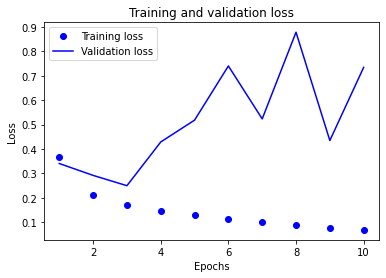

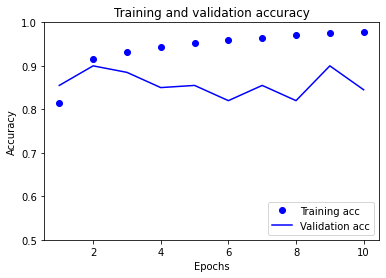

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [56]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(8185, 16)


In [0]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()


In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
